# A/B-тестирование

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy import stats
from statsmodels.stats import power
from matplotlib import pyplot as plt

A/B-тестирование — метод сравнения эффективности контента в двух группах.

### Пример: игра Cookie cats

Cookie cats — игра типа три в ряд. Группы уровней разделены "воротами", открыть которые можно за некоторые игровые ресурсы.

In [7]:
from IPython.display import Image
Image(url="./img/Cookie-cats-gate.jpg") 

Изначально первые "ворота" находились после 30-го уровня. Создатели игры задались вопросом: "Не отпугивает ли эта фича пользователей? Может, первые ворота находятся слишком близко к старту?"

Игроков разделили на контрольную и тестовую группы, для игроков контрольной группы ничего не изменилось, для игроков тестовой группы прохождение первых "ворот" сдвинулось на 40-й уровень.

In [15]:
data = pd.read_csv("../data/cookie_cats.csv")
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


В этом датасете собраны два типа метрик:
 * `sum_gamerounds` — количество пройденных пользователем уровней,
 * `retention_1` — вернулся ли пользователь в игру после установки в течение дня (`retention_7` — через 7 дней соответственно).
 
Естественно считать, что показателем успеха эксперимента будет увеличение **среднего количества пройденных уровней**, исследуем метрику `sum_gamerounds`.

In [16]:
data = data.drop_duplicates(subset=['userid']).drop(columns=['retention_1', 'retention_7'])
A = data[data.version == "gate_30"].reset_index(drop=True)
B = data[data.version == "gate_40"].reset_index(drop=True)
A.head()

,userid,version,sum_gamerounds
0,116,gate_30,3
1,337,gate_30,38
2,1066,gate_30,0
3,2101,gate_30,0
4,2179,gate_30,39


На значение среднего сильно влияют выбросы. Проверим их наличие.

<Axes: >

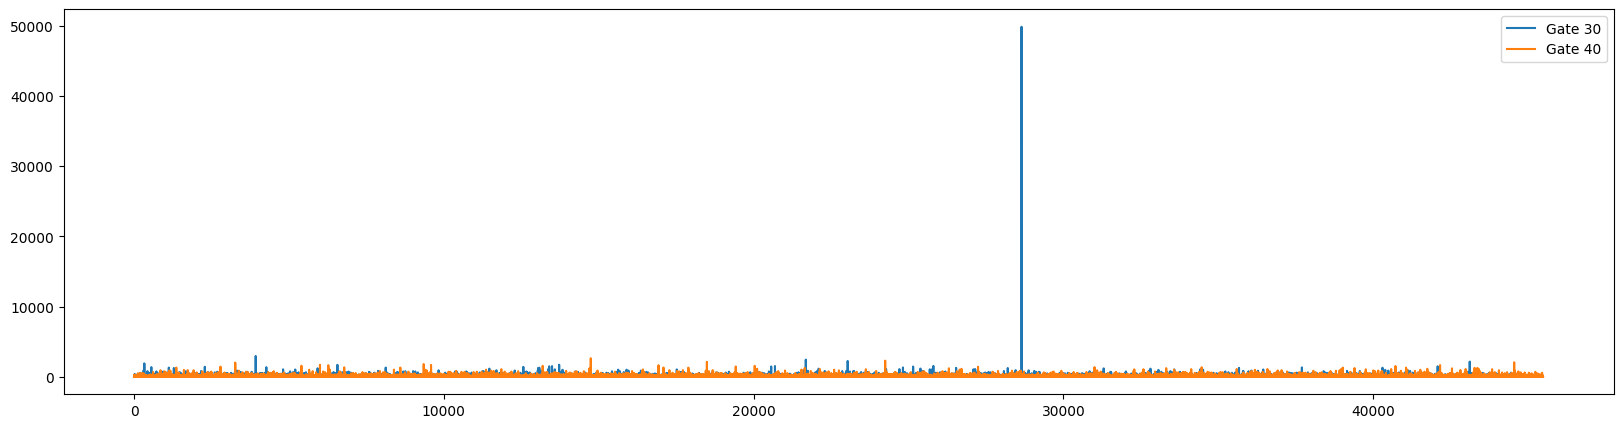

In [9]:
A.sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
B.sum_gamerounds.plot(legend = True, label = "Gate 40")

In [12]:
# Коэффициент вариации
def cv(x):
    return np.std(x, ddof=1) / np.mean(x) * 100 

data.groupby("version").sum_gamerounds.agg(["count", "median", "max", "mean", "var", "std", cv])

,count,median,max,mean,var,std,cv
version,,,,,,,
gate_30,44700,17.0,49854,52.456264,65903.321897,256.716423,489.391359
gate_40,45489,16.0,2640,51.298776,10669.736422,103.294416,201.358444


Можем пожертвовать тем самым максимумом в 49854 раундов

<Axes: >

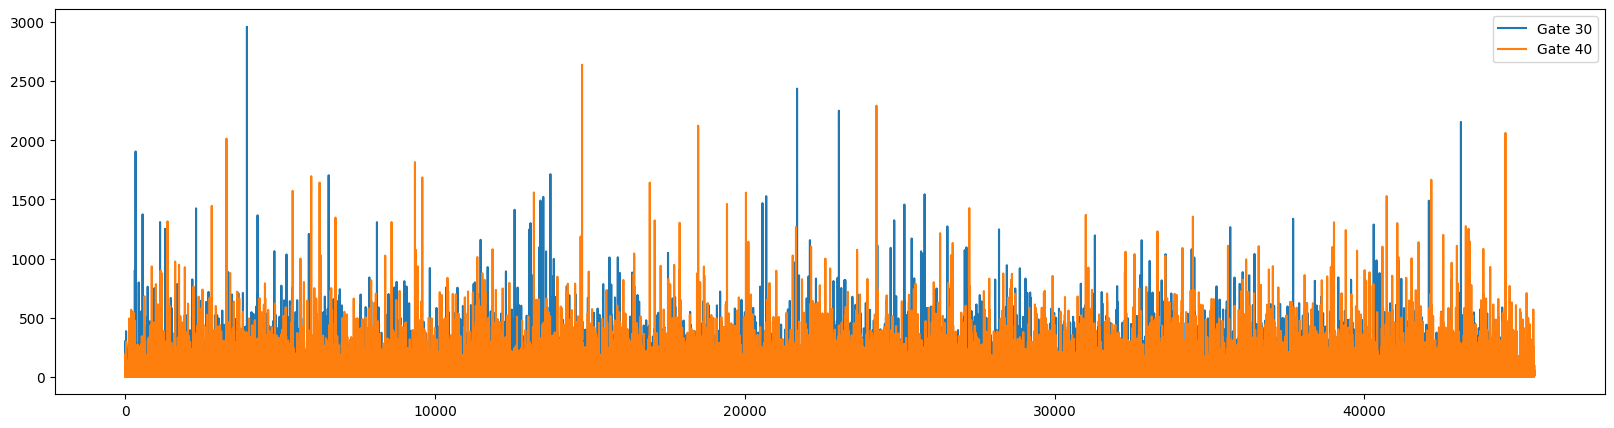

In [17]:
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
A = data[data.version == "gate_30"].reset_index(drop=True)
B = data[data.version == "gate_40"].reset_index(drop=True)
A.sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
B.sum_gamerounds.plot(legend = True, label = "Gate 40")

In [11]:
data.groupby("version").sum_gamerounds.agg(["count", "median", "max", "mean", "var", "std", cv])

,count,median,max,mean,var,std,cv
version,,,,,,,
gate_30,44699,17.0,2961,51.342111,10415.753288,102.057598,198.779514
gate_40,45489,16.0,2640,51.298776,10669.736422,103.294416,201.358444


Среднее для `gate_30` заметно уменьшилось.

В целом наблюдаем небольшое уменьшение среднего количества пройденных уровней в группе  `gate_40`. Теперь нужно определить, можем ли мы сделать вывод об уменьшении среднего (разница статистически значима) или это случайное отклонение (разница не статистически значима). Для этого используются статистические критерии.

### T-критерий: <br>
$H_0: \mu_1 = \mu_2$ — нет статистически значимой разницы<br>
$H_1: \mu_1 \neq \mu_2$

Критерий требует:
- независимости данных (считаем соблюденным)
- нормального распределения средних
- в случае t-критерия требуется равенство дисперсий (для случая неравных дисперсий используются другие вариации критерия)

### 1/3 Проверим нормальность распределения средних

Заметим, что по ЦПТ это верно для многих выборок

100%|██████████| 1000/1000 [03:21<00:00,  4.96it/s]


<Axes: ylabel='Density'>

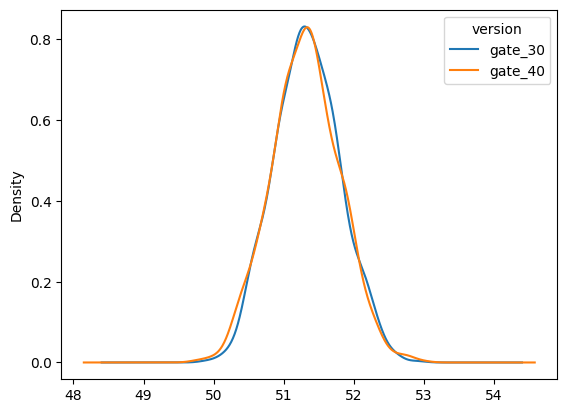

In [57]:
n = 1000
boot = []
for i in tqdm(range(n)):
    boot_mean = data.sample(frac = 1, replace = True).groupby('version').sum_gamerounds.mean()
    boot.append(boot_mean)
boot = pd.DataFrame(boot)
boot[["gate_30", "gate_40"]].plot(kind='density')

Визуально можем оценить, что распределение близко к нормальному, но, чтобы подтвердить это, также воспрользуемся критерием.

#### Тест Шапиро-Уилка<br>
$H_0$ — распределение нормально<br>
$H_1$ — распределение ненормально<br>

$\alpha$ — уровень значимости, вероятность совершить ошибку первого рода (отвергнуть верную $H_0$)<br>
Мы считаем верной нулевую гипотезу, если не было доказано обратное. Считаем, что обратное доказано, если $p-value$ критерия меньше $\alpha$

In [64]:
alpha = 0.05
pvalue = stats.shapiro(boot.gate_30).pvalue
if pvalue < alpha:
    print("Опровергли нормальность распределения. P-value:",  pvalue)
else:
    print("Распределение нормально. P-value:", pvalue)

Распределение нормально. P-value: 0.36139789230919284


In [65]:
pvalue = stats.shapiro(boot.gate_40).pvalue
if pvalue < alpha:
    print("Опровергли нормальность распределения. P-value:",  pvalue)
else:
    print("Распределение нормально. P-value:", pvalue)

Распределение нормально. P-value: 0.7695628400478345


### 2/3 Проверим равенство дисперсий выборок

#### [Тест Левена](https://en.wikipedia.org/wiki/Levene%27s_test)<br>
$H0: \sigma_1 = \sigma_2 = ... = \sigma_k$<br>
$H1:$ хотя бы в одной группе дисперсия не равна остальным 

In [68]:
stats.levene(A.sum_gamerounds, B.sum_gamerounds).pvalue

0.7840494387892463

### 3/3 Используем T-критерий

In [71]:
alpha = 0.05
pvalue = stats.ttest_ind(A.sum_gamerounds, B.sum_gamerounds, equal_var=True).pvalue
if pvalue < alpha:
    print("Опровергли отсутствие статзначимости разности средних. P-value:",  pvalue)
else:
    print("Разность средних не статзначима. P-value:", pvalue)

Разность средних не статзначима. P-value: 0.9494739458256001


Можно заметить, что графики плотностей вероятности значений A и B похожи:

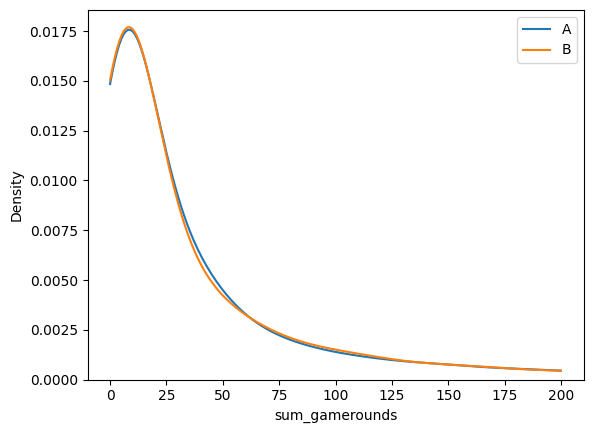

In [18]:
sns.kdeplot(A.sum_gamerounds, clip=(0.0, 200.0), label='A') 
sns.kdeplot(B.sum_gamerounds, clip=(0.0, 200.0), label='B')
plt.legend()

### Пример опровержения $H_0$ на синтетических данных

Возьмём синтетические нормально распределённые данные и посмотрим, как выглядело бы отклонение нулевой гипотезы.

In [89]:
N = 1000
normal_data1 = stats.norm(loc=2, scale=2).rvs(size=N)
normal_data2 = stats.norm(loc=5, scale=3).rvs(size=N)

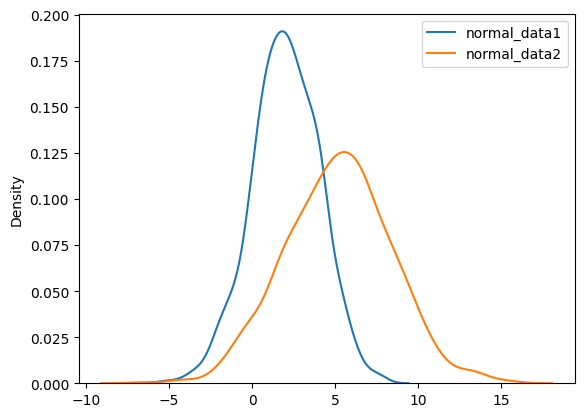

In [90]:
sns.kdeplot(normal_data1, label='normal_data1') 
sns.kdeplot(normal_data2, label='normal_data2')
plt.legend()

In [91]:
pvalue = stats.ttest_ind(normal_data1, normal_data2, equal_var=False).pvalue
if pvalue < alpha:
    print("Опровергли отсутствие статзначимости разности средних. P-value:",  pvalue)
else:
    print("Разность средних не статзначима. P-value:", pvalue)

Опровергли отсутствие статзначимости разности средних. P-value: 3.3406968118932844e-130


# Мощность

Итак, мы умеем делать вывод о значимости разницы в метриках. Но этот вывод, конечно, может оказаться ошибочным. Ошибки могут быть:
* I рода (false positive), $H_0$ была отвергнута, хотя на самом деле верна (заключили наличие эффекта, когда его нет)
* II рода (false negative), неверная $H_0$ была принята (не обнаружен присутствующий эффект)

Вероятность совершить ошибку I рода мы задаём как раз параметром $\alpha$ (уровнем значимости). Как правило этот параметр не больше 0.05.<br>А для определения вероятности ошибки II рода нужно ввести ещё одно понятие.

$\beta$ — уровень **мощности** (чувствительности)<br>
$(1 - \beta)$ — вероятность совершить ошибку II рода

In [46]:
def plot_pvalue_evolution(A, B, alpha, step=100):
    a_size = 0
    sizes = []
    pvals = []
    while a_size < len(A):
        a_size = min(a_size + step, len(A))
        b_size = min(a_size, len(B))
        a_sample = A[:a_size]
        b_sample = B[:b_size]
        sizes.append(a_size)
        pvals.append(stats.ttest_ind(a_sample, b_sample, equal_var=False).pvalue)

    plt.plot(sizes, pvals)
    plt.axhline(y=alpha, color='r')
    plt.show()

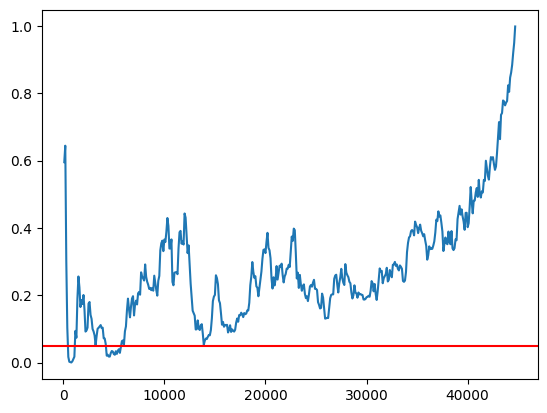

In [47]:
plot_pvalue_evolution(A.sum_gamerounds, B.sum_gamerounds, 0.05)

Заметно, что значение p-value сильно колеблется и, имея достаточно маленькую выборку мы чаще делаем заключение о принятии $H_0$. Это наглядно демонстрирует зависимость вероятности совершить ошибку II рода от размера выборки.

Допустим, мы точно знаем, что из $1000$ тестов $700$ с верной $H_0$ и $300$ с неверной.<br>
Тогда при $\alpha = 0.05$ и $\beta = 0.8$:<br>
* В случае верной $H_0$ мы или подтвердим её, или совершим ошибку I рода.<br>
То есть, для $700 \cdot 0.05 = 35$ тестов мы скажем, что нашли значимый эффект, когда его нет, и выпустим экспериментальную фичу, которая позже плохо себя покажет.


* В случае неверной $H_0$ мы или правильно опровергнем гипотезу, или совершим ошибку II рода.<br>
То есть, для $300 \cdot (1 - 0.8) = 60$ тестов мы не поймём, что экспериментальная фича на самом деле успешная.